In [1]:
from langchain_openai import ChatOpenAI

import os
import getpass
os.environ['OPENAI_API_KEY'] = ""

In [2]:
def add(a: int, b: int):
    """Adds two numbers"""
    return a + b

In [3]:
def multiply(a: int, b: int):
    """Multiplies two numbers"""
    return a * b

### Wrapper for a single agent that can both call tools and transfer to other agents

In [4]:
from langgraph.prebuilt.chat_agent_executor import AgentState as PrebuiltAgentState
from langgraph.prebuilt import create_react_agent

In [5]:
class AgentState(PrebuiltAgentState):
    active_agent: str

In [6]:
model = ChatOpenAI(model="gpt-4o")

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, GraphCommand, START, END
from typing import Literal

In [8]:
from langgraph.prebuilt.handoff import create_handoff_tool, HandoffTool

In [9]:
from langchain_core.runnables import RunnableConfig

In [10]:
def make_agent_node(model, tools, system_prompt=None, return_direct: bool = True):
    handoff_tools = [tool for tool in tools if isinstance(tool, HandoffTool)]
    destinations = [tool.metadata["hand_off_to"] for tool in handoff_tools]
    if return_direct:
        destinations.append(END)

    agent = create_react_agent(model, tools, state_schema=AgentState, state_modifier=system_prompt)

    def call_agent(state: AgentState, config: RunnableConfig) -> GraphCommand[Literal[*destinations]]:
        agent_name = config["metadata"]["langgraph_node"]
        active_agent = state.get("active_agent", agent_name)

        # return right away if we need to switch to a different agent
        if active_agent != agent_name:
            return GraphCommand(goto=active_agent)

        # call agent & determine state update / where we need to go next
        response = agent.invoke(state)
        goto = response.get("active_agent", agent_name)
        update = {"messages": response["messages"][-1], "active_agent": goto}

        if goto == agent_name and return_direct:
            goto = END

        return GraphCommand(update=update, goto=goto)

    return call_agent

In [11]:
bob_tool = create_handoff_tool("bob", name="transfer_to_bob")
alice_tool = create_handoff_tool("alice", name="transfer_to_alice")
charlie_tool = create_handoff_tool("charlie", name="transfer_to_charlie")

In [12]:
builder = StateGraph(AgentState)

alice = make_agent_node(model, [add, bob_tool], system_prompt="You're Alice.")
bob = make_agent_node(model, [multiply, alice_tool], system_prompt="You're Bob.")

builder.add_node("alice", alice)
builder.add_node("bob", bob)
builder.add_edge(START, "alice")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [13]:
from IPython.display import display, Image

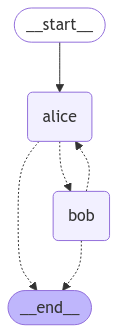

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": "1"}}

In [16]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'messages': AIMessage(content='You have been successfully transferred to Bob!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 102, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'stop', 'logprobs': None}, id='run-750076e6-6112-41b5-aeab-647e0b8c12d0-0', usage_metadata={'input_tokens': 102, 'output_tokens': 9, 'total_tokens': 111, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'active_agent': 'bob'}}


{'bob': {'messages': AIMessage(content='How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 

In [17]:
for chunk in graph.stream({"messages": [("user", "who am i speaking to?")]}, config):
    print(chunk)
    print("\n")

{'alice': None}


{'bob': {'messages': AIMessage(content="You're speaking to Bob. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 109, 'total_tokens': 122, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'stop', 'logprobs': None}, id='run-4727c391-743b-438b-8b03-e58938f67000-0', usage_metadata={'input_tokens': 109, 'output_tokens': 13, 'total_tokens': 122, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'active_agent': 'bob'}}




In [18]:
for chunk in graph.stream({"messages": [("user", "what's 3 times 14?")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

((), {'alice': None})


(('bob:6493e960-209a-bee6-ce87-80092b1a8b9e',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LO8aqlZ1NoOsVnq1OjU6Gk8D', 'function': {'arguments': '{"a":3,"b":14}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 137, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-657dfa92-9487-4a1e-a164-089a340066e8-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 14}, 'id': 'call_LO8aqlZ1NoOsVnq1OjU6Gk8D', 'type': 'tool_call'}], usage_metadata={'input_tokens': 137, 'output_tokens': 17, 'total_tokens': 154, 'input_token_details

In [19]:
for chunk in graph.stream({"messages": [("user", "cool, now transfer me back to alice")]}, config):
    print(chunk)
    print("\n")

{'alice': None}


{'bob': {'messages': AIMessage(content='You have been successfully transferred back to Alice!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 189, 'total_tokens': 199, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'stop', 'logprobs': None}, id='run-2068443f-3ced-40d0-8c6b-c2d3f471662e-0', usage_metadata={'input_tokens': 189, 'output_tokens': 10, 'total_tokens': 199, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'active_agent': 'alice'}}


{'alice': {'messages': AIMessage(content='Welcome back! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage':

In [20]:
for chunk in graph.stream({"messages": [("user", "what's 4 + 9")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('alice:43763c90-69ef-251a-4d26-da95bca2d862',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4ID2dJLOC6NE0ZdvJMxM2Kgr', 'function': {'arguments': '{"a":4,"b":9}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 197, 'total_tokens': 214, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9a6b49bb-e70a-450b-b912-9ccd8f34d513-0', tool_calls=[{'name': 'add', 'args': {'a': 4, 'b': 9}, 'id': 'call_4ID2dJLOC6NE0ZdvJMxM2Kgr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 197, 'output_tokens': 17, 'total_tokens': 214, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

---

In [21]:
builder = StateGraph(AgentState)

alice = make_agent_node(model, [add, bob_tool], system_prompt="You're Alice the cat.")
bob = make_agent_node(model, [multiply, alice_tool, charlie_tool], system_prompt="You're Bob the dog.")
charlie = make_agent_node(model, [bob_tool], system_prompt="You're Charlie the parrot.")

builder.add_node("alice", alice)
builder.add_node("bob", bob)
builder.add_node("charlie", charlie)
builder.add_edge(START, "alice")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

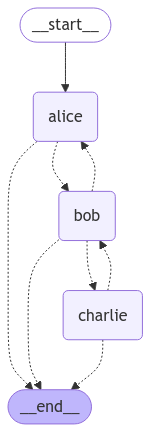

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'messages': AIMessage(content="You've been successfully transferred to 'bob'!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 96, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'stop', 'logprobs': None}, id='run-6ea92008-ed70-4b29-88be-b3bba5114e94-0', usage_metadata={'input_tokens': 96, 'output_tokens': 10, 'total_tokens': 106, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'active_agent': 'bob'}}


{'bob': {'messages': AIMessage(content='If you need any help, feel free to ask!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'pro

In [26]:
for chunk in graph.stream({"messages": [("user", "transfer me to charlie")]}, config):
    print(chunk)
    print("\n")

{'alice': None}


{'bob': {'messages': AIMessage(content="You've been successfully transferred to 'charlie'! If there's anything else you need, just let me know.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 157, 'total_tokens': 180, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'stop', 'logprobs': None}, id='run-06952f0d-fc93-4500-ae3c-cd4abe1d8328-0', usage_metadata={'input_tokens': 157, 'output_tokens': 23, 'total_tokens': 180, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'active_agent': 'charlie'}}


{'charlie': {'messages': AIMessage(content="If there's anything else you need, just let me know!", addit

In [27]:
for chunk in graph.stream({"messages": [("user", "back to bob please")]}, config):
    print(chunk)
    print("\n")

{'alice': None}


{'charlie': {'messages': AIMessage(content="You've been successfully transferred to 'bob'! If you need assistance with anything else, just let me know.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 163, 'total_tokens': 186, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a7d06e42a7', 'finish_reason': 'stop', 'logprobs': None}, id='run-42d019ea-bbff-4a8a-b515-54e97e97b457-0', usage_metadata={'input_tokens': 163, 'output_tokens': 23, 'total_tokens': 186, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'active_agent': 'bob'}}


{'bob': {'messages': AIMessage(content="You're back with 'bob'! If you need assistance with anything

---

### Supervisor

This is a bit broken right now. The biggest issue is that the supervisor tries to answer by itself even though it technically calls "transfer". This is because our approach is different from swarm where the agent object is literally swapped under the hood.

In [44]:
builder = StateGraph(AgentState)

supervisor_tool = create_handoff_tool("supervisor", name="transfer_to_supervisor")

supervisor = make_agent_node(model, [alice_tool, bob_tool], system_prompt=(
    "You're team supervisor managing Alice and Bob. "
    "Alice is an expert at multiplication, Bob is great at addition. "
    "To answer user question, transfer to one of them that has the requisite skills. "
    "Once you have the final answer to user question, do not transfer -- respond to user directly!"
))
alice = make_agent_node(model, [multiply, supervisor_tool], system_prompt="You're Alice. Once you're done multiplying, call to supervisor.", return_direct=False)
bob = make_agent_node(model, [add, supervisor_tool], system_prompt="You're Bob. Once you're done adding, call to supervisor.", return_direct=False)

builder.add_node("supervisor", supervisor)
builder.add_node("alice", alice)
builder.add_node("bob", bob)
builder.add_edge(START, "supervisor")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

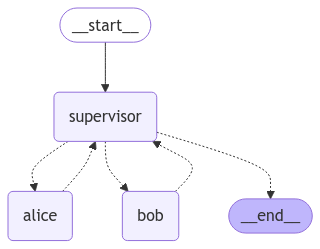

In [45]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
# for chunk in graph.stream({"messages": [("user", "what's 391 + 193")]}, config, subgraphs=True):
#     print(chunk)
#     print("\n")